## Dog Breed Detection using Deep Neural Network
### Softmax Layer for Multiclass Detection
### Currently classifies into 3 Categories

### softmax function changed

### Imports

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math

%matplotlib inline

### Directory

In [2]:
DATADIR = "C:/Users/Omkar/ML and DS/Dog/dataset/softmax"

In [3]:
CATEGORIES = ["German1","Golden1","Pug1"]
img_size = 64

### Training Data List

In [4]:
training_data=[]

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array,(img_size,img_size))
            training_data.append([new_array, class_num])

In [5]:
create_training_data()
print(len(training_data))

1004


In [6]:
random.shuffle(training_data)

### Separating Training List into Features and Label

In [7]:
X = []
y_unsorted = []
for features, label in training_data:
    X.append(features)
    y_unsorted.append(label)

### Transforming Labels into correct format

In [8]:
import numpy as np

def one_hot(labels,C):
    mapping = {}
    for i in range(C):
        mapping[i]=i
    one_hot_encode = []
    for l in labels:
        arr = list(np.zeros(C, dtype = int))
        arr[mapping[l]] = 1
        one_hot_encode.append(arr)
    return one_hot_encode

In [9]:
y = one_hot(y_unsorted,len(CATEGORIES))

### Transforming List to Array

In [10]:
X = np.array(X)
y = np.array(y)

In [11]:
print("Shape of X = "+ str(X.shape))
print("Shape of y = " + str(y.shape))

Shape of X = (1004, 64, 64, 3)
Shape of y = (1004, 3)


In [12]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

### Transforming Arrays to correct Dimension

In [13]:
y_train = y_train.T 
y_test = y_test.T

y= [0 0 1]


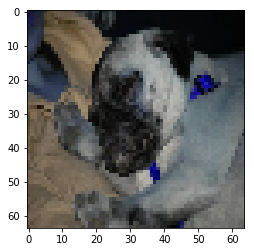

In [15]:
index = 245
plt.imshow(x_train[index])
print("y= "+ str(y_train[:,index]))

#German = [1,0,0]
#Golden = [0,1,0]
#Pug = [0,0,1]

### Exploring Dataset

In [16]:
m_train = x_train.shape[0]
m_test = x_test.shape[0]
num_px = x_train.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(x_train.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_x shape: " + str(x_test.shape))
print ("test_set_y shape: " + str(y_test.shape))

Number of training examples: m_train = 803
Number of testing examples: m_test = 201
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (803, 64, 64, 3)
train_set_y shape: (3, 803)
test_set_x shape: (201, 64, 64, 3)
test_set_y shape: (3, 201)


In [17]:
train_set_x_flatten = x_train.reshape(x_train.shape[0], -1).T
test_set_x_flatten = x_test.reshape(x_test.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(y_test.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 803)
train_set_y shape: (3, 803)
test_set_x_flatten shape: (12288, 201)
test_set_y shape: (3, 201)
sanity check after reshaping: [ 85 149 131  31  79]


In [18]:
train_x = train_set_x_flatten/255.
test_x = test_set_x_flatten/255.

### Helper Functions

In [19]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A,cache

In [20]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert(dZ.shape == Z.shape)
    return dZ

In [97]:
def softmax(Z):
    #exps = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    #exps = np.exp(Z)
    '''cache = Z
    Z -= np.max(Z)
    sm = (np.exp(Z).T / np.sum(np.exp(Z),axis=1)).T
    #return exps / np.sum(exps,axis=1, keepdims = True), cache
    return sm,cache'''
    e_x = np.exp(Z - np.max(Z))
    A = e_x / e_x.sum(axis=0, keepdims=True)
    cache = Z
    
    return A, cache

### Initialization

In [98]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l],
                                                   layer_dims[l-1])*(np.sqrt(2. / layer_dims[l-1]))
        
        parameters["b" + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l],
                                                  layer_dims[l-1]))
        
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

### Forward Prop

In [99]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [100]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache"
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "softmax":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache"
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [101]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2    # number of layers in the neural network
    
    # Implement [LINEAR -> SIGMOID]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W'+ str(l)],
                                             parameters['b'+ str(l)],
                                             activation = "sigmoid")
        caches.append(cache)
    
    # Implement LINEAR -> SOFTMAX. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)],
                                          parameters['b' + str(L)],
                                          activation= "softmax")
    caches.append(cache)
    # LOOk HERE
    assert(AL.shape == (3,X.shape[1]))
            
    return AL, caches

### Cost Function

In [102]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    cost = -(1/m) * np.sum(np.multiply(np.log(AL),Y))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost 

### Back prop

#### Linear Backprop

In [103]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [104]:
def linear_activation_backward(dA,dZL, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "softmax":
        dZ = dZL 
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    return dA_prev, dW, db

In [105]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - np.divide(Y, AL)   # d_cost/d_AL derivation
    dZL = AL - Y               #8:26 Training a softmax classifier
    # Lth layer (SIGMOID -> LINEAR) gradients.
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, dZL, current_cache, activation = "softmax")

    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], dZL,
                                   current_cache, activation = "sigmoid")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Update Parameters

In [106]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W"+ str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    return parameters

### Model

In [107]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.02, num_iterations = 3000, print_cost=False):#lr was 0.009
    np.random.seed(1)
    costs = []                  # keep track of cost
    
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost
        cost = compute_cost(AL, Y)
    
        # Backward propagation
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
                
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

### Test

Cost after iteration 0: 1.344110
Cost after iteration 1000: 0.910372
Cost after iteration 2000: 0.821082
Cost after iteration 3000: 0.750091
Cost after iteration 4000: 0.692689
Cost after iteration 5000: 0.643492
Cost after iteration 6000: 0.599466
Cost after iteration 7000: 0.559302
Cost after iteration 8000: 0.522240
Cost after iteration 9000: 0.487805
Cost after iteration 10000: 0.455704
Cost after iteration 11000: 0.425742
Cost after iteration 12000: 0.397772
Cost after iteration 13000: 0.371666
Cost after iteration 14000: 0.347301


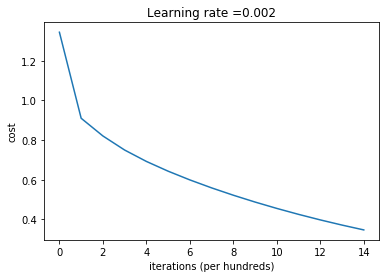

In [108]:
layer_dims = [12288,4,3] # 4-layer
parameters = L_layer_model(train_x,y_train,layer_dims,learning_rate=0.002 , num_iterations=15000,print_cost=True)

In [109]:
y_train.shape

(3, 803)

### Predict

In [110]:
def predict(X, y):
    
    predictions, caches = L_model_forward(X, parameters)
    
    return predictions


In [111]:
def make_pred(X, y):
    
    predictions = predict(X, y)

    y_hat = np.argmax(predictions, axis = 0)
    y_label = np.argmax(y, axis = 0)

    return y_hat, y_label

In [112]:
y_hat, y_label = make_pred(train_x,y_train)
score = accuracy_score(y_label,y_hat)
print("Training accuracy: "+ str(score*100)+ " %")

Training accuracy: 95.51681195516812 %


In [113]:
y_hat, y_label = make_pred(test_x,y_test)
score = accuracy_score(y_label,y_hat)
print("Training accuracy: "+ str(score*100)+ " %")

Training accuracy: 61.69154228855721 %
